In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
from matplotlib.collections import PatchCollection
import numpy as np

%matplotlib inline

* 4ft by 2ft box
* caps are 1 1/8 in
* set up grid
* import image
* if avg pixel intensity is > threshold, dark, else light

* Circle packing problem, this is the a2 lattice method, and the caps make an equilateral triangle, so the distance between rows is the height of an equilateral triangle with side length equal to D
* $D\frac{\sqrt(3)}{2}$ == `1.125*sqrt(3)/2`

In [2]:
import imageio
img=imageio.mimread('/Users/andrew/Downloads/La1200.gif')[0]
# img=plt.imread('/Users/andrew/Downloads/lagunitas-dog-solidPaws-2017.png')
# img=plt.imread('/Users/andrew/Downloads/lags_dog_shading.jpg')

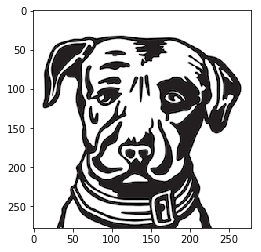

In [3]:
imgplot = plt.imshow(img)

In [14]:
class Circle:
    def __init__(self, diameter):
        self.diameter=diameter
        self.pixel_values=0
        
    def place(self, x, y):
        self.x = x
        self.y = y
    
class Grid:
    def __init__(self, xsize, ysize):
        self.xsize=xsize
        self.ysize=ysize
        
    def _find_row_height(self, C):
        
        return C.diameter * np.sqrt(3)/2
    
    def _make_circle(self, x, y, diameter):
        
        _C = Circle(diameter)
        _C.place(x, y)
        return _C
        
    def get_coords(self, C):

        self.coords = []
        
        num_x = np.floor(self.xsize/C.diameter)
        num_y = np.floor(self.ysize/self._find_row_height(C))
        
        xcoords_leftjust = np.arange(C.diameter/2, self.xsize-C.diameter/2, C.diameter)
        xcoords_rightjust = np.arange(C.diameter, self.xsize-C.diameter/2, C.diameter)
        ycoords = np.arange(C.diameter/2, self.ysize-C.diameter/2, self._find_row_height(C))
        
        leftjust=1
        for i in ycoords:
            if leftjust == 1:
                self.coords.extend([(xc, i) for xc in xcoords_leftjust])
            else:
                self.coords.extend([(xc, i) for xc in xcoords_rightjust])
            leftjust *= -1
            
    def populate(self, C):
        self.get_coords(C)
        self.Circles = [self._make_circle(x, y, C.diameter) for (x, y) in self.coords]
        

class TableMaker:
    
    def __init__(self, image, table_width, table_height, cap_size):
        self.image = image
        self.table_width = table_width
        self.table_height = table_height
        self.cap_size = cap_size
        
    def make_empty_table(self, table_width, table_height, cap_size):
        
        C = Circle(cap_size)

        G = Grid(table_width, table_height)

        G.populate(C)
        
        return G
        
    def _set_corners(self, bordersize, voffset, hoffset):
        
        self.corners = [
            (self.table_width-(self.table_height-2*bordersize))/2 + hoffset, # left
            self.table_width-(self.table_width-(self.table_height-2*bordersize))/2 + hoffset, #right
            bordersize + voffset, # bottom
            self.table_height-bordersize + voffset # top
                       ]

    def overlay(self, bordersize, voffset, hsoffset):
        
        self.grid = self.make_empty_table(self.table_width, self.table_height, self.cap_size)
        
        self._set_corners(bordersize, voffset, hsoffset)
        
        fig, ax = plt.subplots(figsize=(12, 6))
        circlepatches = []
        for x in self.grid.Circles:
            circle = matplotlib.patches.Circle((x.x, x.y), x.diameter/2)
            circlepatches.append(circle)

        pc = PatchCollection(circlepatches, alpha=0.3)

        ax.add_collection(pc)

        ax.set_xlim([0, self.grid.xsize])
        ax.set_ylim([0, self.grid.ysize])

        ax.imshow(img, interpolation='nearest', extent=self.corners)
        plt.show()
        
    def _point_in_circle(self, x_point, y_point, x_circle, y_circle, r):

        return (x_point - x_circle)*(x_point - x_circle) + (y_point - y_circle)*(y_point - y_circle) < r*r
        
    def fit(self):
        
        self.grid = self.make_empty_table(self.table_width, self.table_height, self.cap_size)
        
        pixel_offset = (self.corners[1] - self.corners[0]) / self.image.shape[0]
        xcoords_im = np.linspace(self.corners[0], self.corners[1], num=self.image.shape[1]) + pixel_offset
        ycoords_im = np.linspace(self.corners[2], self.corners[3], num=self.image.shape[0]) + pixel_offset

        for x in range(len(xcoords_im)):
            for y in range(len(ycoords_im)):
                for c in self.grid.Circles:
                    if self._point_in_circle(xcoords_im[x], ycoords_im[y], c.x, c.y, c.diameter/2):
                        c.pixel_values += self.image[self.image.shape[0]-y,x].mean()
                        break
            if x % 50 == 0:
                print("done with ", x, " out of ", len(xcoords_im))
        
    def set_caps(self, cutoff, show_image=True):
        
        fig, ax = plt.subplots(figsize=(12, 6))
        circlepatches = []
        for x in self.grid.Circles:
            fcolor = '#F4D03F' if x.pixel_values > cutoff else '#196F3D'
            circle = matplotlib.patches.Circle((x.x, x.y), x.diameter/2, facecolor=fcolor)
            circlepatches.append(circle)

        pc = PatchCollection(circlepatches, alpha=0.3, match_original=True)

        # Add collection to axes
        ax.add_collection(pc)

        ax.set_xlim([0, self.grid.xsize])
        ax.set_ylim([0, self.grid.ysize])

        print("num gold: ", np.sum([x.pixel_values > cutoff for x in self.grid.Circles]))
        print("num green: ", np.sum([x.pixel_values < cutoff for x in self.grid.Circles]))
        
        if show_image:
            ax.imshow(img, interpolation='nearest', extent=self.corners, alpha=0.4)
        
        plt.show()
            

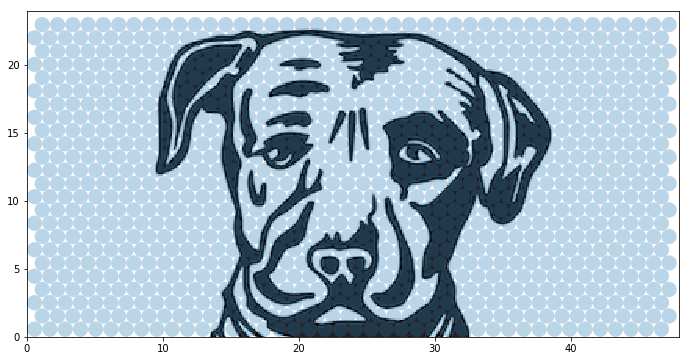

In [15]:
tm = TableMaker(img, 48, 24, 1.125)
tm.overlay(-4, -1.65, 0)

In [16]:
tm.fit()

done with  0  out of  278
done with  50  out of  278
done with  100  out of  278
done with  150  out of  278
done with  200  out of  278
done with  250  out of  278


num gold:  404
num green:  604


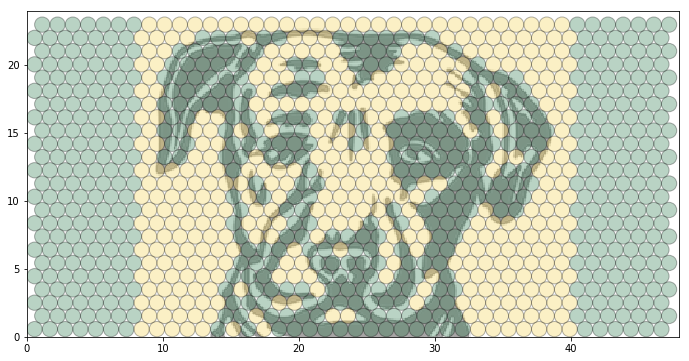

In [18]:
tm.set_caps(14000, show_image=True)

## Old Code

In [ ]:
C = Circle(1.125)

G = Grid(48, 24)

G.populate(C)

In [ ]:
from matplotlib.collections import PatchCollection

BORDERSIZE = -4
VOFFSET = -1.65
HOFFSET = 0

fig, ax = plt.subplots(figsize=(12, 6))
circlepatches = []
for x in G.Circles:
    circle = matplotlib.patches.Circle((x.x, x.y), x.diameter/2)
    circlepatches.append(circle)

pc = PatchCollection(circlepatches, alpha=0.3)

# Add collection to axes
ax.add_collection(pc)

ax.set_xlim([0, G.xsize])
ax.set_ylim([0, G.ysize])

corners = [(G.xsize-(G.ysize-2*BORDERSIZE))/2 + HOFFSET, 
           G.xsize-(G.xsize-(G.ysize-2*BORDERSIZE))/2 + HOFFSET,
           BORDERSIZE + VOFFSET, G.ysize-BORDERSIZE + VOFFSET]

ax.imshow(img, interpolation='nearest', extent=corners, cmap='Greys_r')
plt.show()

> Be careful: in NumPy indexing, the first dimension (camera.shape[0]) corresponds to rows, while the second (camera.shape[1]) corresponds to columns, with the origin (camera[0, 0]) on the top-left corner.

In [ ]:
def point_in_circle(x_point, y_point, x_circle, y_circle, r):

    return (x_point - x_circle)*(x_point - x_circle) + (y_point - y_circle)*(y_point - y_circle) < r*r

pixel_offset = (corners[1] - corners[0]) / img.shape[0]
xcoords_im = np.linspace(corners[0], corners[1], num=img.shape[1]) + pixel_offset
ycoords_im = np.linspace(corners[2], corners[3], num=img.shape[0]) + pixel_offset

for x in range(len(xcoords_im)):
    for y in range(len(ycoords_im)):
        for c in G.Circles:
            if point_in_circle(xcoords_im[x], ycoords_im[y], c.x, c.y, c.diameter/2):
                c.pixel_values += img[img.shape[0]-y,x].mean()
                break
    if x % 50 == 0:
        print("done with ", x, " out of ", len(xcoords_im))

In [ ]:
CUTOFF = 14000

fig, ax = plt.subplots(figsize=(12, 6))
circlepatches = []
for x in G.Circles:
    fcolor = '#F4D03F' if x.pixel_values > CUTOFF else '#196F3D'
    circle = matplotlib.patches.Circle((x.x, x.y), x.diameter/2, facecolor=fcolor)
    circlepatches.append(circle)

pc = PatchCollection(circlepatches, alpha=0.3, match_original=True)

# Add collection to axes
ax.add_collection(pc)

ax.set_xlim([0, G.xsize])
ax.set_ylim([0, G.ysize])

print("num gold: ", np.sum([x.pixel_values > CUTOFF for x in G.Circles]))
print("num green: ", np.sum([x.pixel_values < CUTOFF for x in G.Circles]))

plt.savefig('LAGS_RENDERING_{0}_{1}_{2}.png'.format(VOFFSET, HOFFSET, CUTOFF))

# ax.imshow(img, interpolation='nearest', extent=corners, alpha=0.4, cmap='Greys_r')
plt.show()